# PG Diploma - Machine Learning and Artificial Intelligence

## Assignment - Reinforcement Learning Project - Group Case Study

**By:**
1. **Deepa Kushwaha**
2. **Prateek Ralhan - Group Facilitator**

#### Let us start by stating the objective that we need to accomplish through this assignment.

### Objective:
You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers.Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

### Cab-Driver Agent

In [1]:
# Importing libraries

import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model

from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs

import matplotlib.pyplot as plt

# Import the environment

from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided

Time_matrix = np.load("TM.npy")

#### Check what the max, min and mean time values are. This will help us in defining the 'next_step' function in the Environment.

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Since the max time is 11 hours between any 2 points, the next state of the cab driver may increase at most by  1 day.

### 2. Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):

        # Define size of state and action
        
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        
        self.model = self.build_model()

    # approximate Q function using Neural Network
    
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets       
        
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        
        if np.random.rand() <= self.epsilon:
            
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            
            # Sample batch from the memory
            
            mini_batch = random.sample(self.memory, self.batch_size)
            
            # initialise two matrices - update_input and update_output
            
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            
            target = self.model.predict(update_input)
            
            # target for q-network
            
            target_qval = self.model.predict(update_output)


            # update the target values
            
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            # model fit
            
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

### DQN block

In [5]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 20000
m = 5
t = 24
d = 7

# Invoke Env class

env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.

state_size = m+t+d
action_size = len(action_space)

# Invoke agent class

agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode

rewards_per_episode, episodes = [], []

# Rewards for state [0,0,0] being tracked.

rewards_init_state = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### The init state is randomly picked from the state space for each episode

In [6]:
# Run the episodes, build up replay buffer and train the model.

start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    
    env = CabDriver()
    action_space, state_space, state = env.reset()
    
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    
    while not done:
        
        # 1. Get a list of the ride requests driver got.
        
        possible_actions_indices, actions = env.requests(state)
        
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        
        # 4. Total time driver rode in this episode
        
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        
        else:
            
            # 5. Append the experience to the memory
            
            agent.append_sample(state, action, reward, next_state, done)
            
            # 6. Train the model by calling function agent.train_model
            
            agent.train_model()
            
            # 7. Keep a track of rewards, Q-values, loss
            
            score += reward
            state = next_state

    # store total reward obtained in this episode
    
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)



Saving Model 0
episode 9, reward -545.0, memory_length 1419, epsilon 0.9955001547284723 total_time 723.0
episode 19, reward -364.0, memory_length 2000, epsilon 0.9905350769930761 total_time 725.0
episode 29, reward -60.0, memory_length 2000, epsilon 0.9855947626861951 total_time 721.0
episode 39, reward -4.0, memory_length 2000, epsilon 0.9806790882997144 total_time 723.0
episode 49, reward -474.0, memory_length 2000, epsilon 0.9757879309415182 total_time 726.0
episode 59, reward -251.0, memory_length 2000, epsilon 0.9709211683324178 total_time 723.0
episode 69, reward 9.0, memory_length 2000, epsilon 0.9660786788030947 total_time 726.0
episode 79, reward 99.0, memory_length 2000, epsilon 0.9612603412910584 total_time 721.0
episode 89, reward 63.0, memory_length 2000, epsilon 0.9564660353376199 total_time 723.0
episode 99, reward -243.0, memory_length 2000, epsilon 0.9516956410848808 total_time 726.0
episode 109, reward 93.0, memory_length 2000, epsilon 0.9469490392727365 total_time 7

episode 889, reward 149.0, memory_length 2000, epsilon 0.6411383568390387 total_time 724.0
episode 899, reward 509.0, memory_length 2000, epsilon 0.6379406659439346 total_time 728.0
episode 909, reward 285.0, memory_length 2000, epsilon 0.6347589235987051 total_time 726.0
episode 919, reward 507.0, memory_length 2000, epsilon 0.631593050259626 total_time 721.0
episode 929, reward 205.0, memory_length 2000, epsilon 0.6284429667796988 total_time 723.0
episode 939, reward 735.0, memory_length 2000, epsilon 0.6253085944066726 total_time 729.0
episode 949, reward 699.0, memory_length 2000, epsilon 0.6221898547810748 total_time 721.0
episode 959, reward 484.0, memory_length 2000, epsilon 0.6190866699342522 total_time 722.0
episode 969, reward 1144.0, memory_length 2000, epsilon 0.6159989622864221 total_time 727.0
episode 979, reward 613.0, memory_length 2000, epsilon 0.6129266546447325 total_time 721.0
episode 989, reward 226.0, memory_length 2000, epsilon 0.6098696702013323 total_time 722.0

episode 1779, reward 565.0, memory_length 2000, epsilon 0.41085702335792745 total_time 723.0
episode 1789, reward 807.0, memory_length 2000, epsilon 0.40880786540509717 total_time 722.0
episode 1799, reward 927.0, memory_length 2000, epsilon 0.4067689276701942 total_time 721.0
episode 1809, reward 790.0, memory_length 2000, epsilon 0.40474015917966877 total_time 724.0
episode 1819, reward 1026.0, memory_length 2000, epsilon 0.4027215092142031 total_time 721.0
episode 1829, reward 731.0, memory_length 2000, epsilon 0.4007129273074429 total_time 722.0
episode 1839, reward 1033.0, memory_length 2000, epsilon 0.39871436324473586 total_time 721.0
episode 1849, reward 1045.0, memory_length 2000, epsilon 0.3967257670618763 total_time 721.0
episode 1859, reward 819.0, memory_length 2000, epsilon 0.3947470890438561 total_time 723.0
episode 1869, reward 641.0, memory_length 2000, epsilon 0.3927782797236218 total_time 727.0
episode 1879, reward 519.0, memory_length 2000, epsilon 0.390819289880837

episode 2669, reward 1215.0, memory_length 2000, epsilon 0.2632871545461373 total_time 726.0
episode 2679, reward 884.0, memory_length 2000, epsilon 0.261974004384539 total_time 722.0
episode 2689, reward 1031.0, memory_length 2000, epsilon 0.26066740358669477 total_time 721.0
episode 2699, reward 1214.0, memory_length 2000, epsilon 0.25936731948751673 total_time 721.0
episode 2709, reward 810.0, memory_length 2000, epsilon 0.2580737195848345 total_time 721.0
episode 2719, reward 999.0, memory_length 2000, epsilon 0.25678657153858325 total_time 721.0
episode 2729, reward 1152.0, memory_length 2000, epsilon 0.2555058431699948 total_time 726.0
episode 2739, reward 1302.0, memory_length 2000, epsilon 0.25423150246079323 total_time 721.0
episode 2749, reward 1019.0, memory_length 2000, epsilon 0.2529635175523944 total_time 723.0
episode 2759, reward 977.0, memory_length 2000, epsilon 0.25170185674510953 total_time 728.0
episode 2769, reward 920.0, memory_length 2000, epsilon 0.250446488497

episode 3549, reward 1454.0, memory_length 2000, epsilon 0.16956651673105824 total_time 721.0
episode 3559, reward 1211.0, memory_length 2000, epsilon 0.16872080020063768 total_time 725.0
episode 3569, reward 1158.0, memory_length 2000, epsilon 0.16787930169900972 total_time 729.0
episode 3579, reward 1126.0, memory_length 2000, epsilon 0.16704200018866794 total_time 729.0
episode 3589, reward 1140.0, memory_length 2000, epsilon 0.166208874737031 total_time 724.0
episode 3599, reward 1337.0, memory_length 2000, epsilon 0.1653799045159192 total_time 729.0
episode 3609, reward 1197.0, memory_length 2000, epsilon 0.16455506880103385 total_time 724.0
episode 3619, reward 827.0, memory_length 2000, epsilon 0.1637343469714391 total_time 727.0
episode 3629, reward 1427.0, memory_length 2000, epsilon 0.1629177185090465 total_time 723.0
episode 3639, reward 1441.0, memory_length 2000, epsilon 0.16210516299810185 total_time 724.0
episode 3649, reward 954.0, memory_length 2000, epsilon 0.16129666

episode 4429, reward 1573.0, memory_length 2000, epsilon 0.10920701257100535 total_time 721.0
episode 4439, reward 1590.0, memory_length 2000, epsilon 0.10866234032350246 total_time 728.0
episode 4449, reward 1521.0, memory_length 2000, epsilon 0.10812038464016717 total_time 723.0
episode 4459, reward 1521.0, memory_length 2000, epsilon 0.10758113197207911 total_time 723.0
episode 4469, reward 1006.0, memory_length 2000, epsilon 0.10704456883789358 total_time 724.0
episode 4479, reward 1401.0, memory_length 2000, epsilon 0.10651068182350425 total_time 721.0
episode 4489, reward 1736.0, memory_length 2000, epsilon 0.10597945758170793 total_time 721.0
episode 4499, reward 1667.0, memory_length 2000, epsilon 0.10545088283187094 total_time 722.0
episode 4509, reward 1520.0, memory_length 2000, epsilon 0.10492494435959693 total_time 722.0
episode 4519, reward 1566.0, memory_length 2000, epsilon 0.1044016290163968 total_time 721.0
episode 4529, reward 1602.0, memory_length 2000, epsilon 0.10

episode 5309, reward 1780.0, memory_length 2000, epsilon 0.07033329353341192 total_time 728.0
episode 5319, reward 1536.0, memory_length 2000, epsilon 0.06998250476846683 total_time 727.0
episode 5329, reward 1847.0, memory_length 2000, epsilon 0.0696334655697859 total_time 723.0
episode 5339, reward 1262.0, memory_length 2000, epsilon 0.06928616721137094 total_time 726.0
episode 5349, reward 1242.0, memory_length 2000, epsilon 0.06894060101074495 total_time 721.0
episode 5359, reward 1586.0, memory_length 2000, epsilon 0.06859675832873488 total_time 724.0
episode 5369, reward 1353.0, memory_length 2000, epsilon 0.06825463056925578 total_time 723.0
episode 5379, reward 1407.0, memory_length 2000, epsilon 0.06791420917909581 total_time 722.0
episode 5389, reward 1348.0, memory_length 2000, epsilon 0.06757548564770255 total_time 721.0
episode 5399, reward 1533.0, memory_length 2000, epsilon 0.06723845150697004 total_time 728.0
episode 5409, reward 1424.0, memory_length 2000, epsilon 0.06

episode 6179, reward 1473.0, memory_length 2000, epsilon 0.045524255823405545 total_time 721.0
episode 6189, reward 1379.0, memory_length 2000, epsilon 0.04529720265024866 total_time 727.0
episode 6199, reward 1608.0, memory_length 2000, epsilon 0.045071281909517265 total_time 725.0
episode 6209, reward 1283.0, memory_length 2000, epsilon 0.04484648795318105 total_time 730.0
episode 6219, reward 1346.0, memory_length 2000, epsilon 0.04462281516137944 total_time 722.0
episode 6229, reward 1792.0, memory_length 2000, epsilon 0.044400257942280974 total_time 726.0
episode 6239, reward 1451.0, memory_length 2000, epsilon 0.04417881073194358 total_time 725.0
episode 6249, reward 1783.0, memory_length 2000, epsilon 0.04395846799417545 total_time 732.0
episode 6259, reward 1590.0, memory_length 2000, epsilon 0.043739224220396694 total_time 731.0
episode 6269, reward 1537.0, memory_length 2000, epsilon 0.04352107392950154 total_time 722.0
episode 6279, reward 1395.0, memory_length 2000, epsilon

episode 7049, reward 1810.0, memory_length 2000, epsilon 0.029466242289511866 total_time 727.0
episode 7059, reward 1818.0, memory_length 2000, epsilon 0.029319278792979464 total_time 722.0
episode 7069, reward 1465.0, memory_length 2000, epsilon 0.029173048279943936 total_time 724.0
episode 7079, reward 1471.0, memory_length 2000, epsilon 0.029027547094634832 total_time 721.0
episode 7089, reward 1549.0, memory_length 2000, epsilon 0.02888277159951494 total_time 731.0
episode 7099, reward 1491.0, memory_length 2000, epsilon 0.028738718175189356 total_time 723.0
episode 7109, reward 1572.0, memory_length 2000, epsilon 0.028595383220314963 total_time 724.0
episode 7119, reward 1626.0, memory_length 2000, epsilon 0.02845276315151042 total_time 722.0
episode 7129, reward 1665.0, memory_length 2000, epsilon 0.028310854403266573 total_time 721.0
episode 7139, reward 1888.0, memory_length 2000, epsilon 0.028169653427857343 total_time 726.0
episode 7149, reward 1595.0, memory_length 2000, eps

episode 7919, reward 1593.0, memory_length 2000, epsilon 0.0190724575055616 total_time 721.0
episode 7929, reward 933.0, memory_length 2000, epsilon 0.018977333226905934 total_time 724.0
episode 7939, reward 1773.0, memory_length 2000, epsilon 0.018882683382569338 total_time 721.0
episode 7949, reward 1614.0, memory_length 2000, epsilon 0.018788505606300788 total_time 723.0
episode 7959, reward 1861.0, memory_length 2000, epsilon 0.01869479754365095 total_time 726.0
episode 7969, reward 1485.0, memory_length 2000, epsilon 0.0186015568519134 total_time 728.0
episode 7979, reward 1771.0, memory_length 2000, epsilon 0.018508781200065983 total_time 724.0
episode 7989, reward 1310.0, memory_length 2000, epsilon 0.018416468268712564 total_time 725.0
episode 7999, reward 1951.0, memory_length 2000, epsilon 0.018324615750025048 total_time 725.0
Saving Model 8000
episode 8009, reward 1593.0, memory_length 2000, epsilon 0.018233221347685697 total_time 726.0
episode 8019, reward 1412.0, memory_le

episode 8789, reward 1899.0, memory_length 2000, epsilon 0.012344927857697297 total_time 721.0
episode 8799, reward 2078.0, memory_length 2000, epsilon 0.012283357273142198 total_time 721.0
episode 8809, reward 1746.0, memory_length 2000, epsilon 0.012222093773158674 total_time 728.0
episode 8819, reward 1991.0, memory_length 2000, epsilon 0.012161135826156058 total_time 724.0
episode 8829, reward 1683.0, memory_length 2000, epsilon 0.01210048190818249 total_time 722.0
episode 8839, reward 1829.0, memory_length 2000, epsilon 0.01204013050288686 total_time 725.0
episode 8849, reward 1567.0, memory_length 2000, epsilon 0.011980080101480892 total_time 725.0
episode 8859, reward 1942.0, memory_length 2000, epsilon 0.011920329202701425 total_time 724.0
episode 8869, reward 1275.0, memory_length 2000, epsilon 0.011860876312772876 total_time 727.0
episode 8879, reward 1587.0, memory_length 2000, epsilon 0.011801719945369903 total_time 722.0
episode 8889, reward 1680.0, memory_length 2000, eps

episode 9659, reward 1972.0, memory_length 2000, epsilon 0.007990435619914792 total_time 727.0
episode 9669, reward 1701.0, memory_length 2000, epsilon 0.007950583156000935 total_time 721.0
episode 9679, reward 2107.0, memory_length 2000, epsilon 0.007910929457080072 total_time 724.0
episode 9689, reward 1676.0, memory_length 2000, epsilon 0.007871473531807663 total_time 724.0
episode 9699, reward 1870.0, memory_length 2000, epsilon 0.007832214393783524 total_time 721.0
episode 9709, reward 1783.0, memory_length 2000, epsilon 0.007793151061527156 total_time 725.0
episode 9719, reward 1550.0, memory_length 2000, epsilon 0.00775428255845322 total_time 721.0
episode 9729, reward 1769.0, memory_length 2000, epsilon 0.007715607912847108 total_time 725.0
episode 9739, reward 1825.0, memory_length 2000, epsilon 0.007677126157840679 total_time 722.0
episode 9749, reward 1746.0, memory_length 2000, epsilon 0.007638836331388046 total_time 728.0
episode 9759, reward 1908.0, memory_length 2000, ep

episode 10519, reward 1809.0, memory_length 2000, epsilon 0.005197851041555715 total_time 721.0
episode 10529, reward 1411.0, memory_length 2000, epsilon 0.005171926651332619 total_time 723.0
episode 10539, reward 1229.0, memory_length 2000, epsilon 0.005146131559545177 total_time 726.0
episode 10549, reward 1563.0, memory_length 2000, epsilon 0.005120465121314752 total_time 725.0
episode 10559, reward 1514.0, memory_length 2000, epsilon 0.005094926694979046 total_time 723.0
episode 10569, reward 1799.0, memory_length 2000, epsilon 0.00506951564207608 total_time 722.0
episode 10579, reward 1857.0, memory_length 2000, epsilon 0.005044231327328204 total_time 723.0
episode 10589, reward 1592.0, memory_length 2000, epsilon 0.005019073118626231 total_time 724.0
episode 10599, reward 1610.0, memory_length 2000, epsilon 0.004994040387013635 total_time 721.0
episode 10609, reward 1719.0, memory_length 2000, epsilon 0.00496913250667082 total_time 726.0
episode 10619, reward 1791.0, memory_lengt

episode 11379, reward 1798.0, memory_length 2000, epsilon 0.0033812493755490574 total_time 721.0
episode 11389, reward 1957.0, memory_length 2000, epsilon 0.003364385323933774 total_time 725.0
episode 11399, reward 1823.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 721.0
episode 11409, reward 1281.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 722.0
episode 11419, reward 1549.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 726.0
episode 11429, reward 1672.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 721.0
episode 11439, reward 1942.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 726.0
episode 11449, reward 1843.0, memory_length 2000, epsilon 0.003264952710747684 total_time 725.0
episode 11459, reward 1963.0, memory_length 2000, epsilon 0.003248668691167922 total_time 724.0
episode 11469, reward 1801.0, memory_length 2000, epsilon 0.0032324658884746406 total_time 723.0
episode 11479, reward 2034.0, mem

episode 12229, reward 1913.0, memory_length 2000, epsilon 0.002210558677723136 total_time 725.0
episode 12239, reward 1359.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 728.0
episode 12249, reward 1824.0, memory_length 2000, epsilon 0.002188563251372572 total_time 721.0
episode 12259, reward 2000.0, memory_length 2000, epsilon 0.002177647746618221 total_time 727.0
episode 12269, reward 1873.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 729.0
episode 12279, reward 1877.0, memory_length 2000, epsilon 0.00215597978950362 total_time 725.0
episode 12289, reward 1542.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 725.0
episode 12299, reward 1859.0, memory_length 2000, epsilon 0.002134527432164626 total_time 726.0
episode 12309, reward 1801.0, memory_length 2000, epsilon 0.002123881432182913 total_time 724.0
episode 12319, reward 1369.0, memory_length 2000, epsilon 0.0021132885293476253 total_time 729.0
episode 12329, reward 2073.0, memory_

episode 13079, reward 1778.0, memory_length 2000, epsilon 0.0014451964717519742 total_time 729.0
episode 13089, reward 1715.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 726.0
episode 13099, reward 1775.0, memory_length 2000, epsilon 0.0014308165265929267 total_time 724.0
episode 13109, reward 1856.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 727.0
episode 13119, reward 1573.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 722.0
episode 13129, reward 1733.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 728.0
episode 13139, reward 2034.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 721.0
episode 13149, reward 1824.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 727.0
episode 13159, reward 1790.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 722.0
episode 13169, reward 1932.0, memory_length 2000, epsilon 0.001381604187748968 total_time 723.0
episode 13179, reward 1845.0, m

episode 13929, reward 1927.0, memory_length 2000, epsilon 0.0009448257868077017 total_time 727.0
episode 13939, reward 1571.0, memory_length 2000, epsilon 0.0009401134485367081 total_time 721.0
episode 13949, reward 1483.0, memory_length 2000, epsilon 0.0009354246131508923 total_time 723.0
episode 13959, reward 1773.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 735.0
episode 13969, reward 1832.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 724.0
episode 13979, reward 2030.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 725.0
episode 13989, reward 1836.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 728.0
episode 13999, reward 1676.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 727.0
Saving Model 14000
episode 14009, reward 1641.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 722.0
episode 14019, reward 1882.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 723.0
episode 140

episode 14779, reward 1866.0, memory_length 2000, epsilon 0.0006176985516264101 total_time 721.0
episode 14789, reward 1869.0, memory_length 2000, epsilon 0.0006146177672475235 total_time 721.0
episode 14799, reward 1922.0, memory_length 2000, epsilon 0.0006115523483448293 total_time 721.0
episode 14809, reward 2012.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 730.0
episode 14819, reward 1480.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 722.0
episode 14829, reward 1563.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 730.0
episode 14839, reward 1590.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 721.0
episode 14849, reward 1667.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 722.0
episode 14859, reward 1361.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 721.0
episode 14869, reward 1751.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 724.0
episode 14879, reward 1894.0, 

episode 15629, reward 2034.0, memory_length 2000, epsilon 0.0004038326493718161 total_time 729.0
episode 15639, reward 1734.0, memory_length 2000, epsilon 0.00040181852563039963 total_time 727.0
episode 15649, reward 1783.0, memory_length 2000, epsilon 0.00039981444737305236 total_time 724.0
episode 15659, reward 1616.0, memory_length 2000, epsilon 0.00039782036449771305 total_time 724.0
episode 15669, reward 1353.0, memory_length 2000, epsilon 0.00039583622715220606 total_time 725.0
episode 15679, reward 1801.0, memory_length 2000, epsilon 0.0003938619857329943 total_time 726.0
episode 15689, reward 1558.0, memory_length 2000, epsilon 0.0003918975908839396 total_time 722.0
episode 15699, reward 1517.0, memory_length 2000, epsilon 0.00038994299349506833 total_time 727.0
episode 15709, reward 1751.0, memory_length 2000, epsilon 0.000387998144701344 total_time 727.0
episode 15719, reward 1916.0, memory_length 2000, epsilon 0.0003860629958814451 total_time 721.0
episode 15729, reward 1905

episode 16469, reward 1791.0, memory_length 2000, epsilon 0.0002653369580072404 total_time 721.0
episode 16479, reward 1206.0, memory_length 2000, epsilon 0.00026401358440822923 total_time 726.0
episode 16489, reward 2076.0, memory_length 2000, epsilon 0.00026269681116257844 total_time 723.0
episode 16499, reward 2264.0, memory_length 2000, epsilon 0.0002613866053508893 total_time 727.0
episode 16509, reward 1606.0, memory_length 2000, epsilon 0.0002600829342179475 total_time 721.0
episode 16519, reward 2262.0, memory_length 2000, epsilon 0.000258785765171907 total_time 723.0
episode 16529, reward 1663.0, memory_length 2000, epsilon 0.0002574950657834747 total_time 724.0
episode 16539, reward 2283.0, memory_length 2000, epsilon 0.0002562108037850978 total_time 725.0
episode 16549, reward 1989.0, memory_length 2000, epsilon 0.00025493294707016034 total_time 724.0
episode 16559, reward 1794.0, memory_length 2000, epsilon 0.00025366146369217686 total_time 724.0
episode 16569, reward 1449.

episode 17309, reward 2019.0, memory_length 2000, epsilon 0.0001743388044380586 total_time 724.0
episode 17319, reward 1429.0, memory_length 2000, epsilon 0.00017346928602340108 total_time 722.0
episode 17329, reward 1144.0, memory_length 2000, epsilon 0.00017260410434992868 total_time 728.0
episode 17339, reward 1728.0, memory_length 2000, epsilon 0.00017174323778805517 total_time 725.0
episode 17349, reward 2142.0, memory_length 2000, epsilon 0.00017088666481607099 total_time 731.0
episode 17359, reward 1875.0, memory_length 2000, epsilon 0.0001700343640196076 total_time 722.0
episode 17369, reward 1880.0, memory_length 2000, epsilon 0.0001691863140911009 total_time 724.0
episode 17379, reward 2026.0, memory_length 2000, epsilon 0.00016834249382925804 total_time 723.0
episode 17389, reward 2140.0, memory_length 2000, epsilon 0.00016750288213852904 total_time 726.0
episode 17399, reward 1749.0, memory_length 2000, epsilon 0.0001666674580285773 total_time 721.0
episode 17409, reward 15

episode 18149, reward 2127.0, memory_length 2000, epsilon 0.00011454875702638552 total_time 725.0
episode 18159, reward 2148.0, memory_length 2000, epsilon 0.00011397744271726417 total_time 722.0
episode 18169, reward 2266.0, memory_length 2000, epsilon 0.00011340897785014687 total_time 728.0
episode 18179, reward 1800.0, memory_length 2000, epsilon 0.00011284334821338254 total_time 731.0
episode 18189, reward 2123.0, memory_length 2000, epsilon 0.00011228053966620101 total_time 721.0
episode 18199, reward 1814.0, memory_length 2000, epsilon 0.00011172053813835887 total_time 721.0
episode 18209, reward 1780.0, memory_length 2000, epsilon 0.0001111633296297892 total_time 724.0
episode 18219, reward 1671.0, memory_length 2000, epsilon 0.00011060890021024982 total_time 723.0
episode 18229, reward 2134.0, memory_length 2000, epsilon 0.00011005723601897679 total_time 725.0
episode 18239, reward 1737.0, memory_length 2000, epsilon 0.00010950832326433618 total_time 721.0
episode 18249, reward

episode 18999, reward 1738.0, memory_length 2000, epsilon 7.488851626803123e-05 total_time 722.0
Saving Model 19000
episode 19009, reward 1617.0, memory_length 2000, epsilon 7.451500823491522e-05 total_time 726.0
episode 19019, reward 1702.0, memory_length 2000, epsilon 7.414336308088607e-05 total_time 729.0
episode 19029, reward 1267.0, memory_length 2000, epsilon 7.377357151479571e-05 total_time 730.0
episode 19039, reward 1477.0, memory_length 2000, epsilon 7.340562429183548e-05 total_time 724.0
episode 19049, reward 1845.0, memory_length 2000, epsilon 7.303951221330587e-05 total_time 722.0
episode 19059, reward 980.0, memory_length 2000, epsilon 7.267522612638562e-05 total_time 723.0
episode 19069, reward 1509.0, memory_length 2000, epsilon 7.231275692390381e-05 total_time 724.0
episode 19079, reward 1874.0, memory_length 2000, epsilon 7.195209554411128e-05 total_time 724.0
episode 19089, reward 1300.0, memory_length 2000, epsilon 7.1593232970455e-05 total_time 724.0
episode 19099,

episode 19849, reward 2174.0, memory_length 2000, epsilon 4.8959849189243816e-05 total_time 725.0
episode 19859, reward 2027.0, memory_length 2000, epsilon 4.871566092268928e-05 total_time 722.0
episode 19869, reward 1874.0, memory_length 2000, epsilon 4.8472690550195184e-05 total_time 724.0
episode 19879, reward 1913.0, memory_length 2000, epsilon 4.823093199748938e-05 total_time 721.0
episode 19889, reward 1998.0, memory_length 2000, epsilon 4.7990379220595626e-05 total_time 728.0
episode 19899, reward 1665.0, memory_length 2000, epsilon 4.77510262056818e-05 total_time 721.0
episode 19909, reward 1589.0, memory_length 2000, epsilon 4.751286696891023e-05 total_time 726.0
episode 19919, reward 1676.0, memory_length 2000, epsilon 4.7275895556287444e-05 total_time 726.0
episode 19929, reward 1807.0, memory_length 2000, epsilon 4.7040106043515844e-05 total_time 728.0
episode 19939, reward 1780.0, memory_length 2000, epsilon 4.6805492535845425e-05 total_time 721.0
episode 19949, reward 180

##### The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720

In [7]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [8]:
agent.states_tracked

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 454.82877,
 545.1023,
 542.648,
 650.11163,
 755.9737,
 560.4386,
 511.5014,
 554.08765,
 545.40106,
 603.9336,
 604.23834,
 579.4163,
 517.56226,
 669.25116,
 619.34705,
 621.02875,
 704.6674,
 702.26807,
 736.82074,
 676.18854,
 595.82935,
 689.8453,
 1187.5774,
 1180.2137,
 1060.9255,
 2482.5317,
 1779.608,
 396.38037,
 278.49875,
 320.19745,
 400.36154,
 628.39233,
 582.85486,
 618.3105,
 552.0014,
 526.2632,
 518.6553,
 487.29413,
 641.84766,
 500.15005,
 547.4929,
 571.2274,
 471.13837,
 500.85263,
 512.2517,
 535.4955,
 655.43195,
 608.25085,
 599.04193,
 598.3231,
 632.7807,
 596.67255,
 598.473,
 501.07486,
 628.91223,
 644.47003,
 644.258,
 629.6773,
 622.8916,
 656.9229,
 663.19507,
 627.6092,
 614.74164,
 589.2646,
 604.7579,
 656.7164,
 594.525,
 615.69196,
 600.0815,
 690.547,
 557.9638,
 604.1597,
 601.92004,
 658.8092,
 643.75757,
 657.29675,
 558.545

#### Plot the Q-Value convergence for state action pairs

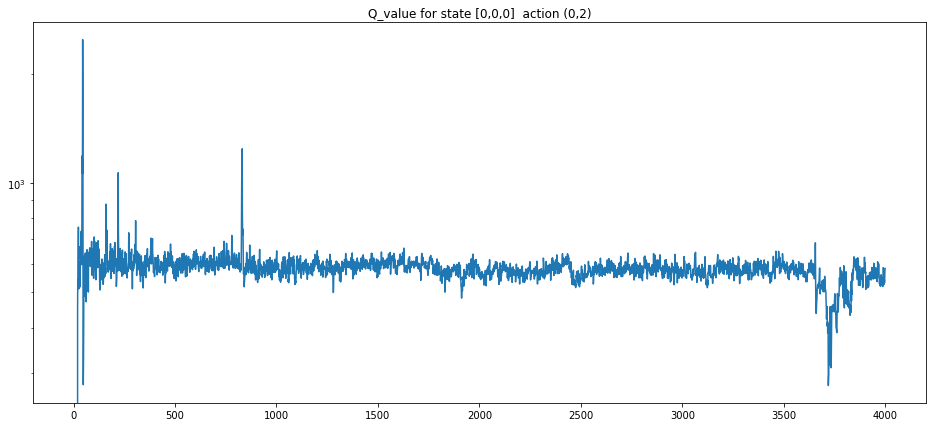

In [9]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

### We are using log scale because the initial q_values are way too high compared to the steady state value ***(~ 400)***

### Track rewards per episode.

In [10]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

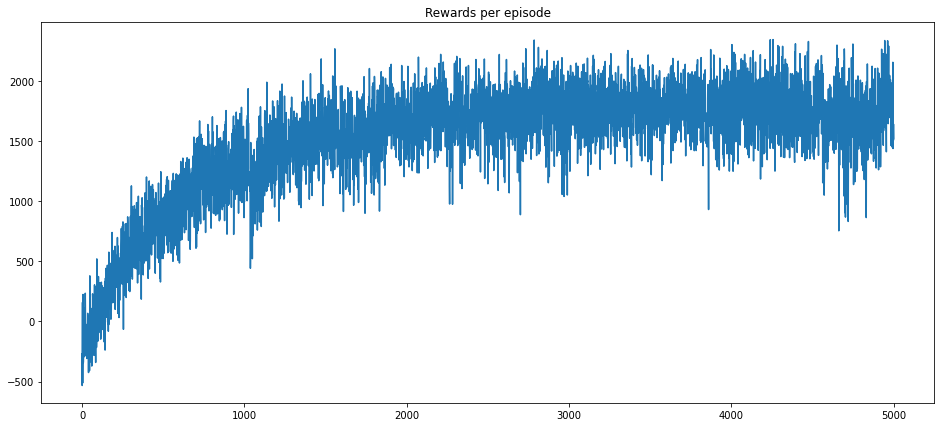

In [11]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

### We can see from the above plot that the rewards converge at around 1500. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [12]:
import numpy as np
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

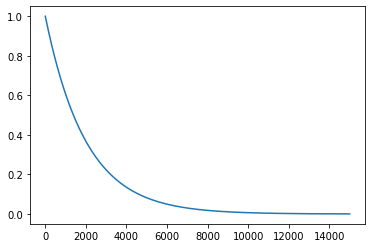

In [13]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()

In [14]:
###############################################################################################################
#                                                                                                             #
#                                          Compiled By:                                                       #
#                                         1. Deepa Kushwaha                                                   #
#                                         2. Prateek Ralhan - Group Facilitator                               #                 
#                                                                                                             #
###############################################################################################################